# Problem Statement

#### You are a cab rental start-up company. You have successfully run the pilot project and now want to launch your cab service across the country. You have collected the historical data from your pilot project and now have a requirement to apply analytics for fare prediction. You need to design a system that predicts the fare amount for a cab ride in the city.

# Importing required packages


In [ ]:

#operations on dataframe and numbers 
import pandas as pd
import numpy as np

# for visualiazations
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec 

#to check the plot inline
%matplotlib inline

# for imputing missing values 
from fancyimpute import KNN

# for datetime
from datetime import datetime
import calendar

#sklearn 
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

# we can use  sklearn.cross_validation or sklearn.model_selection  depending on version
#from sklearn.cross_validation import train_test_split  
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import tree
import warnings
from math import sin, cos, sqrt, atan2, radians,asin
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier    
from sklearn.metrics import roc_auc_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
warnings.filterwarnings('ignore')

In [262]:
#!pip install xgboost
#!pip install hyperopt

In [61]:
train=pd.read_csv("train_cab.csv")

In [37]:
train.head(4)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0


In [38]:
# lets check shape of data frame 
print("Row : Columns")
print(train.shape[0],train.shape[1])

Row : Columns
16067 7


In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16043 non-null object
pickup_datetime      16067 non-null object
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: float64(5), object(2)
memory usage: 878.7+ KB


In [40]:
train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
mean,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,10.578384,6.826587,10.575062,6.187087,60.844122
min,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,-73.966838,40.767381,-73.963643,40.768013,2.000000
max,40.766125,401.083332,40.802437,41.366138,5345.000000


# Data Preparation 

In [62]:
# Converting pickup_datetime object to pandas datetime

# Here one observation is having 43 in pickup_datetime removing that observation 
train=train[train["pickup_datetime"]!="43"]
train["pickup_datetime"]=pd.to_datetime(train["pickup_datetime"],format="%Y-%m-%d %H:%M:%S UTC")
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


### Create datetime features based on pickup_datetime

In [63]:

train["pickup_date"]=train["pickup_datetime"].dt.date
train["pickup_day"]=train["pickup_datetime"].apply(lambda x:x.day)
train["pickup_hour"]=train["pickup_datetime"].apply(lambda x:x.hour)
train["pickup_month"]=train["pickup_datetime"].apply(lambda x:x.month)
train["pickup_year"]=train["pickup_datetime"].apply(lambda x:x.year)
train['pickup_day_of_week']=train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
train=train.drop(['pickup_datetime'], axis=1)
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,pickup_hour,pickup_month,pickup_year,pickup_day_of_week
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009-06-15,15,17,6,2009,Monday
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010-01-05,5,16,1,2010,Tuesday
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011-08-18,18,0,8,2011,Thursday
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012-04-21,21,4,4,2012,Saturday
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010-03-09,9,7,3,2010,Tuesday


In [43]:
train.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_date', 'pickup_day', 'pickup_hour', 'pickup_month',
       'pickup_year', 'pickup_day_of_week'],
      dtype='object')

In [44]:
#train['fare_amount']= train['fare_amount'].apply(pd.to_numeric,errors='coerce')



In [64]:
# removing strings in numerical variables  '430-' in fare
numeric_variables=['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'pickup_day', 'pickup_hour', 'pickup_month',
       'pickup_year']
train[numeric_variables]= train[numeric_variables].apply(pd.to_numeric,errors='coerce')


In [65]:
#KNN imputation
#Assigning levels to the categories
lis = []
for i in range(0, train.shape[1]):
    #print(i)
    if(train.iloc[:,i].dtypes == 'object'):
        train.iloc[:,i] = pd.Categorical(train.iloc[:,i])
        #print(train[[i]])
        train.iloc[:,i] = train.iloc[:,i].cat.codes 
        train.iloc[:,i] = train.iloc[:,i].astype('object')
        
        lis.append(train.columns[i])
        

# Missing Value Analysis 

In [67]:
# creating data frame with missing values 
missing_data=pd.DataFrame(train.isnull().sum())
# reseting index
missing_data=missing_data.reset_index()
# renaming columns
missing_data=missing_data.rename(columns={'index':"features",0:"percentage"})
# converting into percentage
missing_data["percentage"]=(missing_data["percentage"]/len(train))*100
# decending order
missing_data=missing_data.sort_values("percentage", ascending = False).reset_index(drop = True)
# saving in a csv file.
missing_data

,features,percentage
0,passenger_count,0.342338
1,fare_amount,0.155608
2,pickup_longitude,0.000000
3,pickup_latitude,0.000000
4,dropoff_longitude,0.000000
5,dropoff_latitude,0.000000
6,pickup_date,0.000000
7,pickup_day,0.000000
8,pickup_hour,0.000000
9,pickup_month,0.000000


In [ ]:
# knn
train=pd.DataFrame(KNN(k=3).fit_transform(train),columns=train.columns)



In [69]:
#Convert into proper datatypes
caterical_var=["pickup_date","pickup_day_of_week"]
for i in caterical_var:
    train.loc[:,i] = train.loc[:,i].round()
    train.loc[:,i] = train.loc[:,i].astype('object')

In [70]:
# # Let us round passenger_count
train['passenger_count']=train['passenger_count'].round()
# Let us round fare to 2 decimal places
train['fare_amount']=train['fare_amount'].apply(lambda x:round(x,2))


In [71]:
# checking for missing values 
train[pd.isnull(train)].sum()

fare_amount           0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
passenger_count       0.0
pickup_date           0.0
pickup_day            0.0
pickup_hour           0.0
pickup_month          0.0
pickup_year           0.0
pickup_day_of_week    0.0
dtype: float64

In [171]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,pickup_hour,pickup_month,pickup_year,pickup_day_of_week
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,165,15.0,17.0,6.0,2009.0,1
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,369,5.0,16.0,1.0,2010.0,5
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,956,18.0,0.0,8.0,2011.0,4
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,1202,21.0,4.0,4.0,2012.0,2
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,431,9.0,7.0,3.0,2010.0,5


## Exploratory Data Analysis

Text(0.5, 1.0, 'Distribution of Trip Fare')

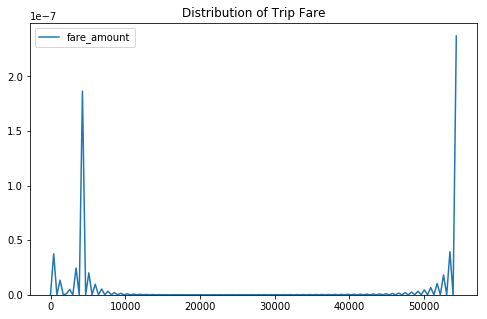

In [72]:
plt.figure(figsize=(8,5))

sns.kdeplot(train["fare_amount"]).set_title("Distribution of Trip Fare")

In [73]:
#max and min fare
print('Maximum Fare: %d  Min Fare:  %d'%(train["fare_amount"].max(), train["fare_amount"].min()))
  


Maximum Fare: 54343  Min Fare:  -3


In [79]:

train[train["fare_amount"]< 0].shape

(0, 12)

There are 3 records with negative fare. We will remove these records from the data

In [80]:
train=train[train["fare_amount"]>=0]
train.shape

(16063, 12)

In [81]:
# Number of Unique values present in each variable
train.nunique()

fare_amount             486
pickup_longitude      13787
pickup_latitude       14237
dropoff_longitude     13883
dropoff_latitude      14260
passenger_count          25
pickup_date            2367
pickup_day               31
pickup_hour              24
pickup_month             12
pickup_year               7
pickup_day_of_week        7
dtype: int64

Since we saw above that fare amount is highly skewed,let us take log transformation of the fare amount and plot the distribution

Text(0.5, 1.0, 'Distribution of fare amount (log scale)')

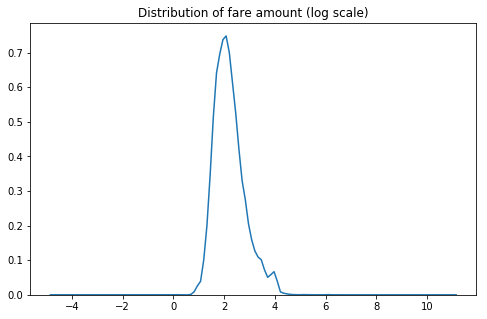

In [82]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['fare_amount'].values)).set_title("Distribution of fare amount (log scale)")

Most fares are between 2.7 and 4.5 dollars 

Let us look at Geographical Features and their relationship with Fare Amount

Distribution of Pickup and Dropoff Lat Lng

In [83]:
print('Range of pickup latitude is ( ',(train.pickup_latitude.max()),',',(train.pickup_latitude.min()),' )')

print('Range of drop off latitude is ( ',(train.dropoff_latitude.max()),',',(train.dropoff_latitude.min()),' )')

Range of pickup latitude is (  401.083332 , -74.006893  )
Range of drop off latitude is (  41.366138 , -74.006377  )


In [84]:
print('Range of pickup longitude is ( ',(train.pickup_longitude.max()),',',(train.pickup_longitude.min()),' )')

print('Range of dropoff longitude is ( ',(train.dropoff_longitude.max()),',',(train.dropoff_longitude.min()),' )')

Range of pickup longitude is (  40.766125 , -74.438233  )
Range of dropoff longitude is (  40.802437 , -74.42933199999999  )



From above values  we can say that The data is for cab Rides in Newyork, whose center lat, lng is at ((40,-74).The range of dropoff and pickup latitudes indicates lot of outlier locations in the train data.

In [85]:
# lets check boundaries for the test data also

test=pd.read_csv("test.csv")
print("Longitude Boundary in test data")
print(min(test.pickup_longitude.min(), test.dropoff_longitude.min()),max(test.pickup_longitude.max(), test.dropoff_longitude.max()))

Longitude Boundary in test data
-74.263242 -72.986532


In [86]:
print("Latitude Boundary in test data")
min(test.pickup_latitude.min(), test.pickup_latitude.min()),max(test.pickup_latitude.max(), test.pickup_latitude.max())

Latitude Boundary in test data


(40.573143, 41.709555)

Let us set the boundary for the train data also based on test data lat lng boundaries.We will mark the outlier locations as 1 and remove them for further analysis

In [87]:
boundary={'min_lng':-74.263242,
              'min_lat':40.573143,
              'max_lng':-72.986532, 
              'max_lat':41.709555}

There are a lot of cases where lat lng is zero. How many such cases are there in the data?

In [88]:
train[(train.pickup_latitude==0) | (train.pickup_longitude)==0 | (train.dropoff_latitude==0)|(train.dropoff_longitude==0)].shape

(314, 12)

let us create a field called is_outlier_loc and mark as 1 in case it is an outlier. Any point beyond NYC border is an outlier. We will also drop all rows where the pickup or dropoff location is an outlier

In [89]:
train.loc[~((train.pickup_longitude >= boundary['min_lng'] ) & (train.pickup_longitude <= boundary['max_lng']) &
            (train.pickup_latitude >= boundary['min_lat']) & (train.pickup_latitude <= boundary['max_lat']) &
            (train.dropoff_longitude >= boundary['min_lng']) & (train.dropoff_longitude <= boundary['max_lng']) &
            (train.dropoff_latitude >=boundary['min_lat']) & (train.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=1


train.loc[((train.pickup_longitude >= boundary['min_lng'] ) & (train.pickup_longitude <= boundary['max_lng']) &
            (train.pickup_latitude >= boundary['min_lat']) & (train.pickup_latitude <= boundary['max_lat']) &
            (train.dropoff_longitude >= boundary['min_lng']) & (train.dropoff_longitude <= boundary['max_lng']) &
            (train.dropoff_latitude >=boundary['min_lat']) & (train.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=0

# train.loc[(train.pickup_latitude==0) | (train.pickup_longitude)==0 | (train.dropoff_latitude==0)|(train.dropoff_longitude==0),'is_outlier_loc']=1

print("Outlier vs Non Outlier Counts")
print(train['is_outlier_loc'].value_counts())


Outlier vs Non Outlier Counts
0.0    15709
1.0      354
Name: is_outlier_loc, dtype: int64


In [90]:
# Let us drop rows, where location is outlier
train=train.loc[train['is_outlier_loc']==0]
train.drop(['is_outlier_loc'],axis=1,inplace=True)

(-74.03, -73.75)

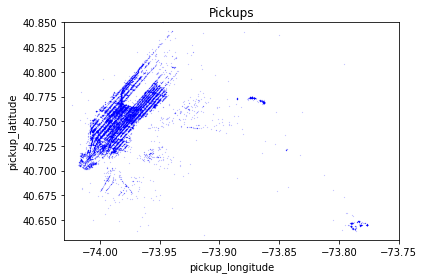

In [91]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)


train.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='blue', 
                s=.02, alpha=.6)
plt.title("Pickups")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

(-74.03, -73.75)

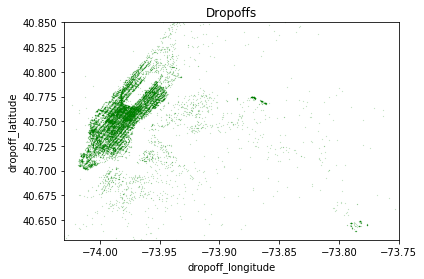

In [92]:

train.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)



In [93]:
pickup_fare_amount=train.groupby(['pickup_latitude','pickup_longitude'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare'})
pickup_fare_amount.head()

,pickup_latitude,pickup_longitude,avg_fare
0,40.604462,-73.780495,5.5
1,40.609495,-74.089848,7.7
2,40.614803,-73.943923,5.5
3,40.616788,-73.928838,12.5
4,40.619563,-73.960442,8.5


### Trip Distance 

In [94]:
'''Using the pickup and drop-off coordinates we calculate the trip distance in miles based on Haversine Distance.'''

#calculate trip distance in miles
def distance(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [95]:
train["trip_distance"]=train.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)

In [96]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,pickup_hour,pickup_month,pickup_year,pickup_day_of_week,trip_distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,165,15.0,17.0,6.0,2009.0,1,0.640487
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,369,5.0,16.0,1.0,2010.0,5,5.250670
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,956,18.0,0.0,8.0,2011.0,4,0.863411
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,1202,21.0,4.0,4.0,2012.0,2,1.739386
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,431,9.0,7.0,3.0,2010.0,5,1.242218


In [97]:
# max  trip distance 
print('Maximum trip distance : %d  '%(train["trip_distance"].max()))
 

Maximum trip distance : 62  


Text(0.5, 1.0, 'Distribution of Trip Distance')

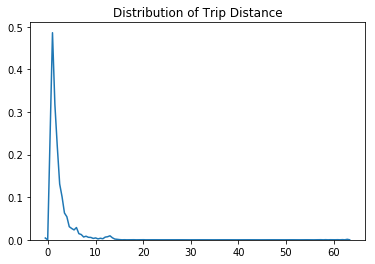

In [98]:
sns.kdeplot(train['trip_distance'].values).set_title("Distribution of Trip Distance")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount')

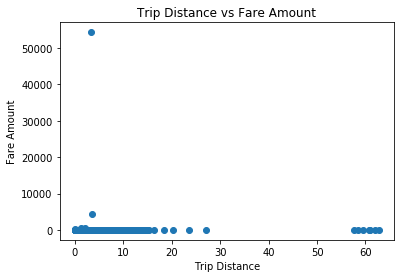

In [99]:
plt.scatter(x=train['trip_distance'],y=train['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount")

In [100]:
train_copy=train.copy()

## Outlier Analysis

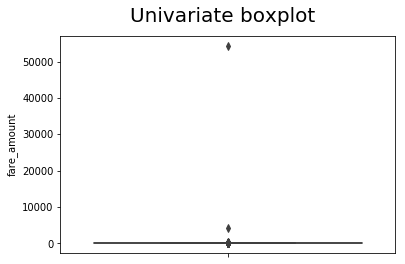

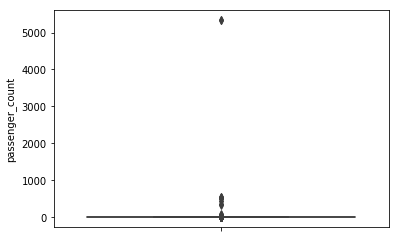

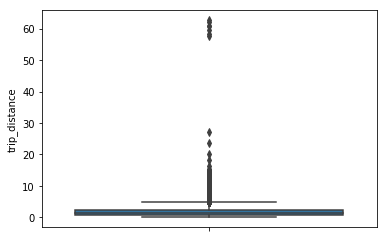

In [102]:
numeric_variables=['fare_amount', 'passenger_count','trip_distance']

plt.suptitle("Univariate boxplot",fontsize=20)
for i in numeric_variables :
    sns.boxplot(
    y = train[i],
    data=train)
    plt.show()
#     plt.savefig("outlier.png")

In [190]:
train[train["fare_amount"]==train["fare_amount"].max()]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,pickup_hour,pickup_month,pickup_year,pickup_day_of_week,trip_distance
1015,54343.0,-74.003319,40.727455,-73.96447,40.764378,1.0,2243,27.0,17.0,2.0,2015.0,0,3.262442


 here no of passengers is 1 and trip distance is 3.2 miles but fare is 54343

In [191]:
train[train["passenger_count"]==train["passenger_count"].max()]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,pickup_hour,pickup_month,pickup_year,pickup_day_of_week,trip_distance
1146,8.0,-73.991098,40.770655,-73.976933,40.79007,5345.0,1907,27.0,8.0,3.0,2014.0,4,1.532548


here passengers count  is 5345.0 and trip distance is 1.5 miles but fare is 8.0

In [103]:
#there are max of 6 passengers in test data so lets remove records having passengers count more than  6
train[train["passenger_count"]>6].shape


(18, 13)

In [104]:
train=train[train["passenger_count"]<=6]

In [105]:
#Detect and replace with NA
numeric_variables=['fare_amount']
for i in numeric_variables:
    q75, q25 = np.percentile(train.loc[:,i], [75, 25]) # #Extract quartiles
    iqr = q75 - q25     # #Calculate IQR
    # #Calculate inner and outer fence
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
    print(min), print(max)
    train.loc[train[i] < minimum,i] = np.nan
    train.loc[train[i] > maximum, i] = np.nan

<built-in function min>
<built-in function max>


In [106]:
train.isnull().sum()

fare_amount           1357
pickup_longitude         0
pickup_latitude          0
dropoff_longitude        0
dropoff_latitude         0
passenger_count          0
pickup_date              0
pickup_day               0
pickup_hour              0
pickup_month             0
pickup_year              0
pickup_day_of_week       0
trip_distance            0
dtype: int64

In [ ]:
# knn imputation
train=pd.DataFrame(KNN(k=3).fit_transform(train),columns=train.columns)


In [108]:
# Let us round fare to 2 decimal places
train['fare_amount']=train['fare_amount'].apply(lambda x:round(x,2))


In [109]:
train.isnull().sum()

fare_amount           0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count       0
pickup_date           0
pickup_day            0
pickup_hour           0
pickup_month          0
pickup_year           0
pickup_day_of_week    0
trip_distance         0
dtype: int64

In [199]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,pickup_hour,pickup_month,pickup_year,pickup_day_of_week,trip_distance
count,15691.000000,15691.000000,15691.000000,15691.000000,15691.000000,15691.000000,15691.000000,15691.000000,15691.000000,15691.000000,15691.000000,15691.000000,15691.000000
mean,9.234712,-73.974744,40.751374,-73.973763,40.751918,1.643681,1170.137276,15.666114,13.505640,6.264801,2011.735517,2.997769,2.093492
std,4.207954,0.041114,0.031316,0.039078,0.033255,1.266191,676.137667,8.685063,6.505203,3.448342,1.867170,2.007458,2.553141
min,0.000000,-74.181602,40.604462,-74.183955,40.574652,0.000000,0.000000,1.000000,0.000000,1.000000,2009.000000,0.000000,0.000000
25%,6.000000,-73.992387,40.736658,-73.991370,40.736393,1.000000,582.000000,8.000000,9.000000,3.000000,2010.000000,1.000000,0.781260
50%,8.200000,-73.982050,40.753370,-73.980570,40.754277,1.000000,1167.000000,16.000000,14.000000,6.000000,2012.000000,3.000000,1.348773
75%,11.700000,-73.968109,40.767810,-73.965386,40.768349,2.000000,1742.000000,23.000000,19.000000,9.000000,2013.000000,5.000000,2.420309
max,22.100000,-73.137393,41.366138,-73.137393,41.366138,6.000000,2366.000000,31.000000,23.000000,12.000000,2015.000000,6.000000,62.817285


In [71]:
#train_copy.sort_values(["trip_distance","fare_amount","passenger_count"], ascending = False).head(100)

In [202]:
train.sort_values(["trip_distance","passenger_count","fare_amount"], ascending = False).head(10)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,pickup_hour,pickup_month,pickup_year,pickup_day_of_week,trip_distance
5526,14.91,-73.137393,41.366138,-74.000940,40.731723,1.0,55.0,25.0,7.0,2.0,2009.0,6.0,62.817285
1633,2.50,-73.137393,41.366138,-73.996510,40.745320,2.0,121.0,2.0,19.0,5.0,2009.0,2.0,61.995186
2996,6.90,-73.137393,41.366138,-73.974598,40.751311,1.0,5.0,6.0,10.0,1.0,2009.0,5.0,60.885112
9665,7.70,-73.974361,40.755168,-73.137393,41.366138,1.0,223.0,12.0,19.0,8.0,2009.0,6.0,60.689692
4376,4.90,-73.137393,41.366138,-73.957685,40.765644,1.0,237.0,26.0,7.0,8.0,2009.0,6.0,59.559694
9577,6.90,-73.137393,41.366138,-73.952331,40.786380,1.0,224.0,13.0,23.0,8.0,2009.0,4.0,58.362662
7227,4.50,-73.900571,40.764047,-73.137393,41.366138,1.0,196.0,16.0,9.0,7.0,2009.0,4.0,57.542607
12067,13.12,-73.797225,40.639720,-73.840545,41.030892,1.0,484.0,1.0,15.0,5.0,2010.0,2.0,27.122079
6153,17.20,-73.422692,40.747012,-73.870317,40.773160,1.0,598.0,23.0,11.0,8.0,2010.0,1.0,23.495875
4014,15.41,-73.776700,40.645400,-73.905900,40.921800,1.0,951.0,13.0,17.0,8.0,2011.0,2.0,20.258276


# Visualization

Let us now look at datetime features and their realtionship with Fare Amount

What is the time period in out sample

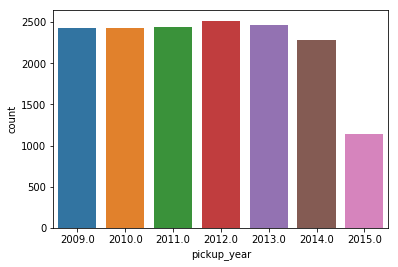

In [110]:
sns.countplot(train['pickup_year'])

In [111]:
trips_year_fare_amount=train.groupby(["pickup_year"])["fare_amount"].mean().reset_index().rename(columns={"fare_amount":"avg_fair_amount"})
trips_year_fare_amount.head()

,pickup_year,avg_fair_amount
0,2009.0,8.565707
1,2010.0,8.529617
2,2011.0,8.734578
3,2012.0,9.160537
4,2013.0,9.902311


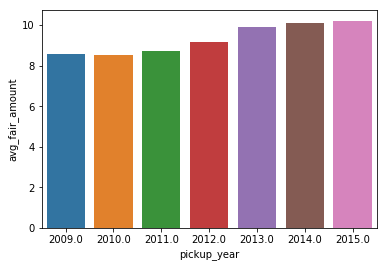

In [210]:
sns.barplot(x='pickup_year',y="avg_fair_amount",data=trips_year_fare_amount)

Avg Fare amount has beern increasing over the years.

In [106]:
test.columns

Index(['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [112]:
def groupAndPlot(data,groupby_key,value,aggregate='mean'):
    plt.figure(figsize=(16,10))
    aggregate_data=data.groupby([groupby_key])[value].agg(aggregate).reset_index().rename(columns={value:aggregate+"_"+value})
    plt.subplot(1,2,1)
    count_data=data.groupby([groupby_key])['fare_amount'].count().reset_index().rename(columns={'fare_amount':"Num_Trips"})
    sns.barplot(x=groupby_key,y='Num_Trips',data=count_data).set_title("Number of Trips vs "+groupby_key)    
    plt.subplot(1,2,2)
    sns.barplot(x=groupby_key,y=aggregate+'_'+value,data=aggregate_data).set_title(aggregate+'_'+value+" vs "+groupby_key)
    

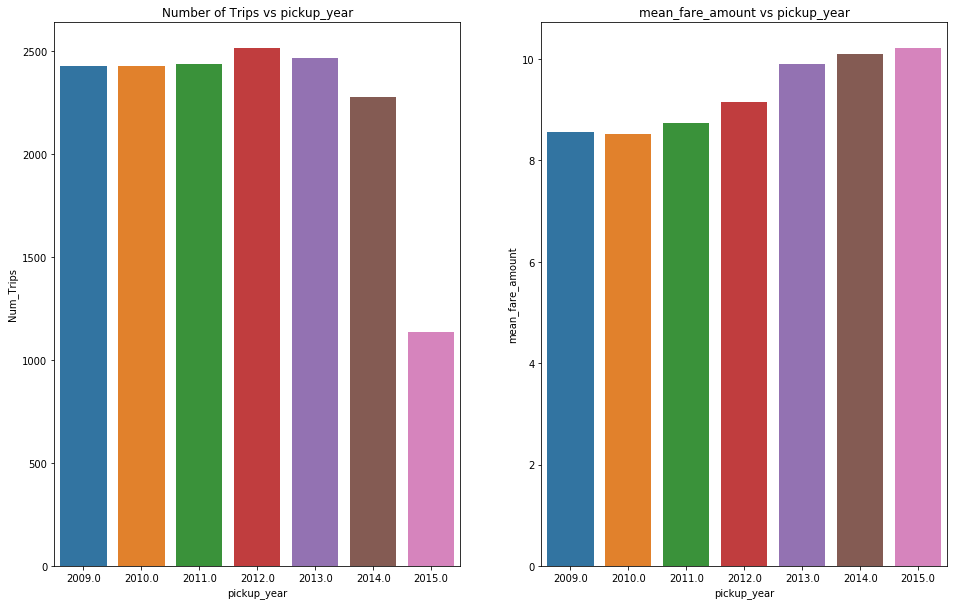

In [410]:
groupAndPlot(train,'pickup_year','fare_amount')

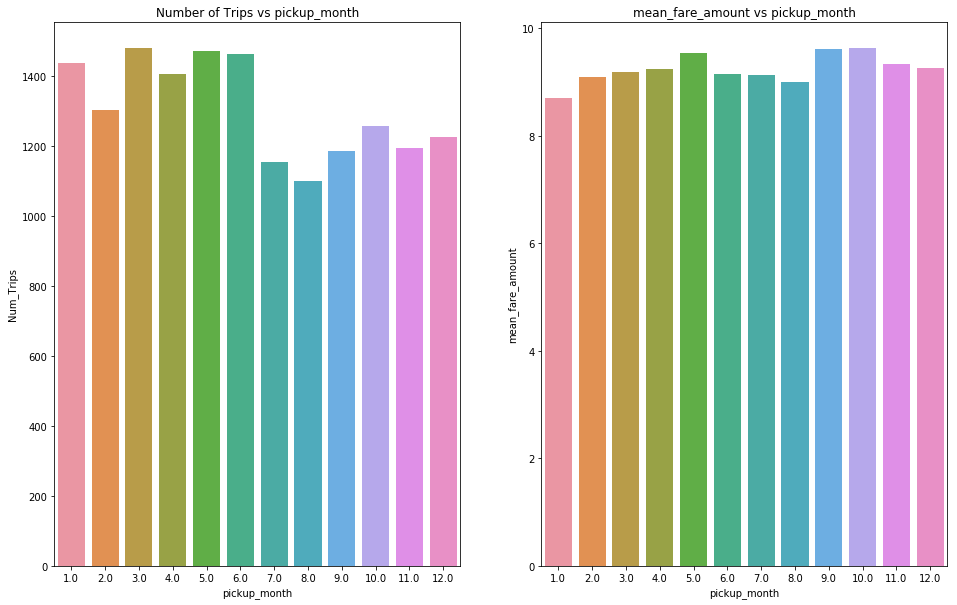

In [212]:
groupAndPlot(train,'pickup_month','fare_amount')

Fares across months are fairly constant, though number of trips are lower from june to decemeber

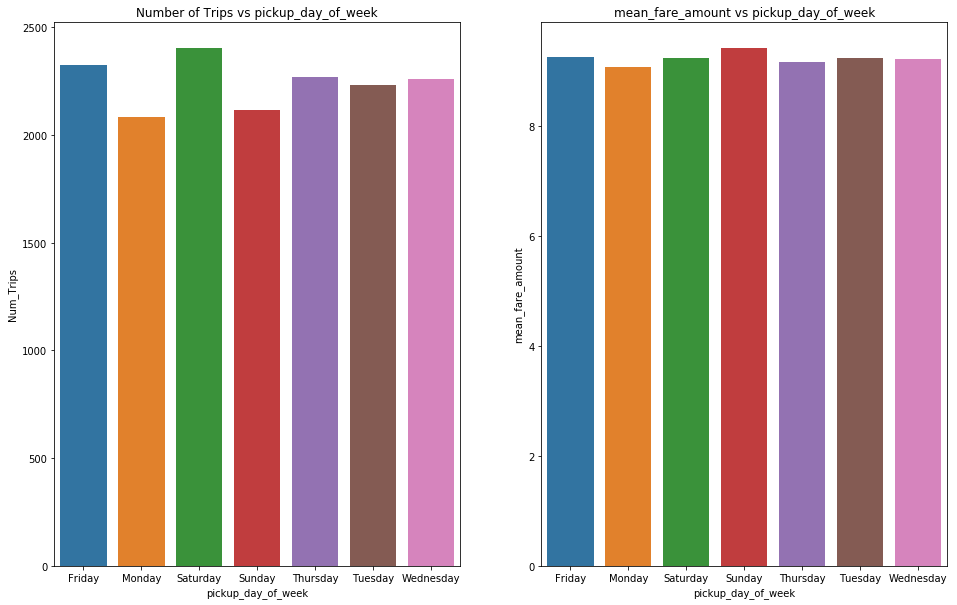

In [113]:
# decoding numbers into days 
def decodeDays(day_of_week):
    day_dict={0:'Friday',1:'Monday',2:'Saturday',3:'Sunday',4:'Thursday',5:'Tuesday',6:'Wednesday'}
    return day_dict[day_of_week]
    
train['pickup_day_of_week']=train['pickup_day_of_week'].apply(lambda x:decodeDays(x))
groupAndPlot(train,'pickup_day_of_week','fare_amount')



Saturday has low avg fare amount, compared to other days though there are a lot of trips of saturday. On sunday and monday though the number of trips are lower, avg fare amount is higher

In [114]:
# Let us encode day of the week to numbers
def encodeDays(day_of_week):
    day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]

In [115]:
train['pickup_day_of_week']=train['pickup_day_of_week'].apply(lambda x:encodeDays(x))

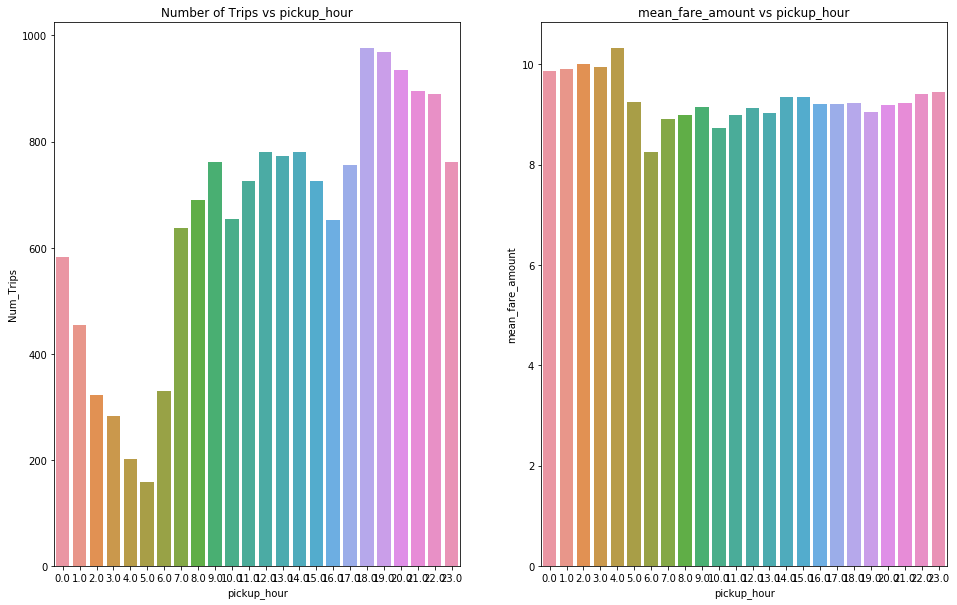

In [116]:
groupAndPlot(train,'pickup_hour','fare_amount')

The avg fare amount at 4am and 5 am are the higher while the number of trips at 4 am and 5 am are the least. The number of trips are highest in 18 and 19 hours

### How does Number of passengers affect Fare time 

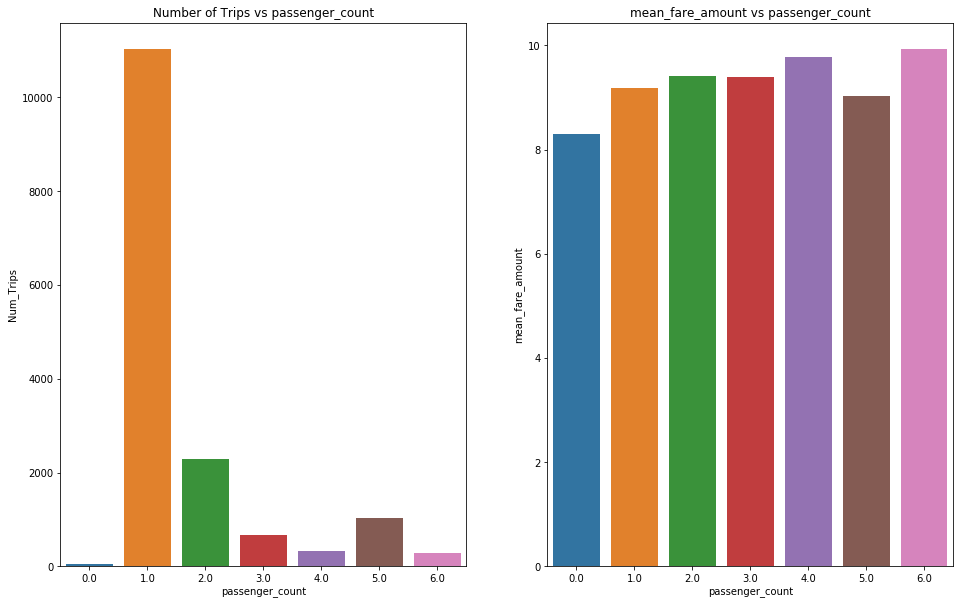

In [216]:
groupAndPlot(train,'passenger_count','fare_amount')


In [221]:
train.loc[train["passenger_count"]==0].shape

(56, 13)

In [222]:
train.loc[train["passenger_count"]==6].shape

(295, 13)

1. There are trips with 0 passengers as well. In these cases are drop and pickup location the same? If so it would mean that passenger didnt take the cab after the cab arrived and a cancellation fee was charged - there were 56 such records.

2.  Fare amount is higher for 6 passengers .no of trips for 6 passengers is very low -there were 295 records

In [214]:
train.to_csv("train_cleaned.csv",index=False)

In [344]:
#train=pd.read_csv("train_cleaned.csv")

In [345]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,pickup_hour,pickup_month,pickup_year,pickup_day_of_week,trip_distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,165.0,15.0,17.0,6.0,2009.0,1,0.640487
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,369.0,5.0,16.0,1.0,2010.0,2,5.250670
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,956.0,18.0,0.0,8.0,2011.0,4,0.863411
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,1202.0,21.0,4.0,4.0,2012.0,6,1.739386
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,431.0,9.0,7.0,3.0,2010.0,2,1.242218


# Correlation plot

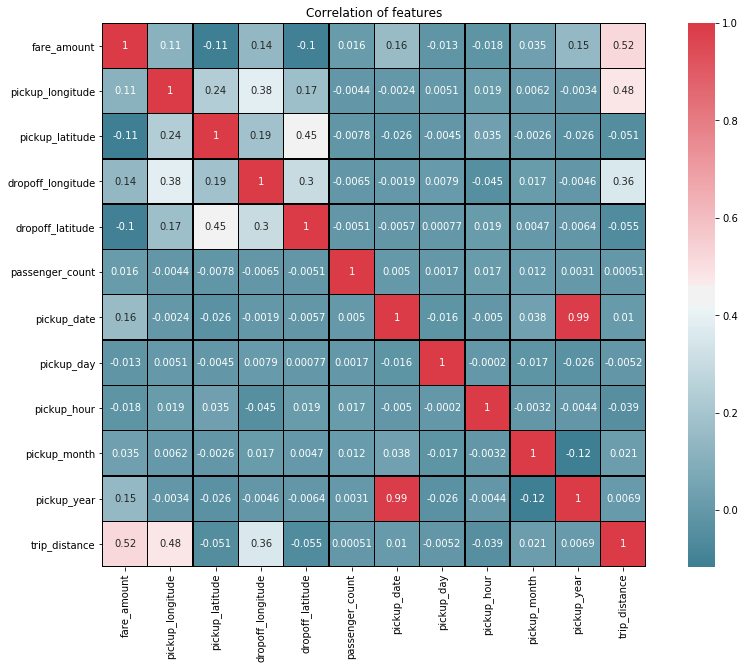

In [237]:
#Correlation Plot
churn_corr = train

#Setting the plot height and width
f, ax = plt.subplots(figsize=(15, 10))

#Generating correlation matrix
corr = churn_corr.corr()

#Ploting using seaborn library
#annot shows the correlation number inside each block
plt.title('Correlation of features')
correlation_plot = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), linewidths=0.4,vmax=1.0,linecolor='k', annot=True,cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
#plt.savefig("correlation_plot.png")



In [205]:
test =  pd.read_csv('test.csv')

In [206]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


# Cleaning test data

In [117]:
test =  pd.read_csv('test.csv')
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')
test['pickup_date']= test['pickup_datetime'].dt.date
test['pickup_day']=test['pickup_datetime'].apply(lambda x:x.day)
test['pickup_hour']=test['pickup_datetime'].apply(lambda x:x.hour)
test['pickup_day_of_week']=test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_month']=test['pickup_datetime'].apply(lambda x:x.month)
test['pickup_year']=test['pickup_datetime'].apply(lambda x:x.year)
test['trip_distance']=test.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)
test['pickup_day_of_week']=test['pickup_day_of_week'].apply(lambda x:encodeDays(x))
for i in range(0, test.shape[1]):
    if(test.iloc[:,i].dtypes == 'object'):
        test.iloc[:,i] = pd.Categorical(test.iloc[:,i])
        test.iloc[:,i] = test.iloc[:,i].cat.codes 
        test.iloc[:,i] = test.iloc[:,i].astype('object')
        
print("Shape of test data", test.shape)
test.to_csv("test_cleaned.csv",index=False)

Shape of test data (9914, 13)


In [118]:
test[pd.isnull(train)].sum()

pickup_datetime       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
passenger_count       0.0
pickup_date           0.0
pickup_day            0.0
pickup_hour           0.0
pickup_day_of_week    0.0
pickup_month          0.0
pickup_year           0.0
trip_distance         0.0
dtype: float64

In [119]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,trip_distance
0,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,1133,27,13,2,1,2015,1.443607
1,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,1133,27,13,2,1,2015,1.507044
2,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,513,8,11,6,10,2011,0.384398
3,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,715,1,21,6,12,2012,1.218529
4,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,715,1,21,6,12,2012,3.347514


In [128]:
#train=pd.read_csv("train_cleaned.csv")
#test=pd.read_csv("test_cleaned.csv")

## Create a function to process data for Modelling

This step includes:

Dropping unwanted columns from the data
One Hot Encoding of categorical variables
Dividing training data into train and validation data sets
features and target varible must be seperated
split ratio must be passed as an argument

In [120]:
def processDataForModelling(data,target,drop_cols,is_train=True,split=0.25):
    data_1=data.drop(drop_cols,axis=1)
    # One hot Encoding
#     data_1=pd.get_dummies(data_1)
    if is_train==True:
        X=data_1.drop([target],axis=1)
        y=data_1[target]
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=split,random_state=123)
        
        print("Shape of Training Features",X_train.shape)
        print("Shape of Validation Features ",X_test.shape)
        
        return X_train, X_test, y_train, y_test
    else:
        print ("Shape of Test Data",data_1.shape)
        return data_1
    

In [121]:
X_train, X_test, y_train, y_test=processDataForModelling(train,'fare_amount',drop_cols=[],is_train=True,split=0.2)

Shape of Training Features (12552, 12)
Shape of Validation Features  (3139, 12)


In [122]:
final_test_data=processDataForModelling(test,'fare_amount',drop_cols=['pickup_datetime'],is_train=False)

Shape of Test Data (9914, 12)


### Building a Baseline Model and Identifying a good ML algorithm for this problem



The metric used in this problem is RMSE. We will try three models - Linear Regression, Random Forest and XGBoost and see which model performs better. We will use the best model among the three to further tune and apply feature Engineering

For Baseline, we will predict the average fare amount and check the RMSE on validation data. Any model, should be able to beat this simple benchmark

In [123]:
avg_fare=round(np.mean(y_train),2)
avg_fare

9.23

In [124]:
baseline_pred=np.repeat(avg_fare,y_test.shape[0])
baseline_rmse=np.sqrt(mean_squared_error(baseline_pred, y_test))
print("Basline RMSE of Validation data :",baseline_rmse)

Basline RMSE of Validation data : 4.201849734517198


### Linear Regression Model

In [125]:
# Build a Linear RegressionModel
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred=np.round(lm.predict(X_test),2)
lm_rmse=np.sqrt(mean_squared_error(y_pred, y_test))
lm_train_rmse=np.sqrt(mean_squared_error(lm.predict(X_train), y_train))
lm_variance=abs(lm_train_rmse - lm_rmse)
print("Test RMSE for Linear Regression is ",lm_rmse)
print("Train RMSE for Linear Regression is ",lm_train_rmse)
print("Variance for Linear Regression is ",lm_variance)
print("RMSE for Linear Regression is ",lm_rmse)

Test RMSE for Linear Regression is  3.4730594059797135
Train RMSE for Linear Regression is  3.46797934693488
Variance for Linear Regression is  0.00508005904483344
RMSE for Linear Regression is  3.4730594059797135


The linear regression model performed better than than the Baseline Mode. Let us create a Random Forest Model and see how it performs. Reason for failure of linear regression model, is that it tries to fit a linear line between the variables and the targer. But, as we saw in the Exploratory analysis phase this is not true.

### Random Forest Model

In [295]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 883,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=883, verbose=0, warm_start=False)

In [413]:
rf_pred= rf.predict(X_test)
rf_rmse=np.sqrt(mean_squared_error(rf_pred, y_test))

rf_train_rmse=np.sqrt(mean_squared_error(rf.predict(X_train), y_train))
rf_variance=abs(rf_train_rmse - rf_rmse)
print("Test RMSE for Random Forest is ",rf_rmse)
print("Train RMSE for Random Forest is ",rf_train_rmse)
print("Variance for Random Forest is ",rf_variance)

Test RMSE for Random Forest is  2.33463315975363
Train RMSE for Random Forest is  0.8758006782424178
Variance for Random Forest is  1.4588324815112124


Random Forest has reduced the RMSE considerably as compared to Linear Regression. Random Forest works on the principle of Bagging The idea behind this is very intutive- when we want to make a decision about a field we do not know about we take advice from a people and then we decide based on the majority opinion. This is the idea behind Random Forest - multiple decision trees are created and output from each of the trees are averaged to predict the value. Random Forest are not susceptible to overfitting and since in Random Forest, each tree is trained independently of the other, it is more robust.

The next type of algorithm we will see is also another Tree based Ensemble algorithm - but it follows concept of Boosting.

### LGB Model

In [227]:


train_data=lgb.Dataset(X_train,label=y_train)

In [228]:
param = {'num_leaves':31, 'num_trees':5000, 'objective':'regression'}
param['metric'] = 'l2_root'

In [229]:
num_round=5000
cv_results = lgb.cv(param, train_data, num_boost_round=num_round, nfold=10,verbose_eval=20, early_stopping_rounds=20,stratified=False)

[20]	cv_agg's rmse: 2.38211 + 0.0699781
[40]	cv_agg's rmse: 2.29509 + 0.0756061
[60]	cv_agg's rmse: 2.27515 + 0.0770271
[80]	cv_agg's rmse: 2.2692 + 0.0794739
[100]	cv_agg's rmse: 2.26429 + 0.0787186
[120]	cv_agg's rmse: 2.25991 + 0.0789751
[140]	cv_agg's rmse: 2.25647 + 0.0795594
[160]	cv_agg's rmse: 2.25695 + 0.0790748


In [230]:
print('Best num_boost_round:', len(cv_results['rmse-mean']))
#lgb_pred = lgb_bst.predict(X_test)

Best num_boost_round: 142


In [231]:
lgb_bst=lgb.train(param,train_data,len(cv_results['rmse-mean']))

In [232]:
lgb_pred = lgb_bst.predict(X_test)
lgb_rmse=np.sqrt(mean_squared_error(lgb_pred, y_test))
print("RMSE for Light GBM is ",lgb_rmse)

RMSE for Light GBM is  2.314828224835188



Light GBM is better than Random Forest . Let us also create a XGBOOST Model and see how it performs.

### XGBOOST Model

In [297]:

dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)

k-fold Cross Validation using XGBoost

In order to build more robust models, it is common to do a k-fold cross validation where all the entries in the original training dataset are used for both training as well as validation. Also, each entry is used for validation just once. XGBoost supports k-fold cross validation via the cv() method. All you have to do is specify the nfolds parameter, which is the number of cross validation sets you want to build. Also, it supports many other parameters (check out this link) like:
* num_boost_round: denotes the number of trees you build (analogous to n_estimators)
* metrics: tells the evaluation metrics to be watched during CV
* as_pandas: to return the results in a pandas DataFrame.
* early_stopping_rounds: finishes training of the model early if the hold-out metric ("rmse" in our case) does not improve for a given number of rounds.
* seed: for reproducibility of results.

In [298]:
xgb_param = {'objective':'reg:squarederror','eval_metric':'rmse'}
xgb_cv=xgb.cv(xgb_param, dtrain, num_boost_round=5000, nfold=5,early_stopping_rounds=20)

In [299]:
nrounds=xgb_cv.shape[0]
nrounds

42

In [300]:
#  reg:linear is now deprecated in favor of reg:squarederror
xbg_model=xgb.train(params={'objective':'reg:squarederror','eval_metric':'rmse'}
                    ,dtrain=dtrain,num_boost_round=nrounds)



In [301]:
xgb_pred=xbg_model.predict(dtest)
xgb_rmse=np.sqrt(mean_squared_error(xgb_pred, y_test))
print("RMSE for XGBOOST is ",xgb_rmse)



RMSE for XGBOOST is  2.292632401010061


### For each of the model we have built above, let us see what is the train RMSE and test RMSE - This will help us understand variance in the model and get the best model

**Mean Absolute Error (MAE):** MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.

 
If the absolute value is not taken (the signs of the errors are not removed), the average error becomes the Mean Bias Error (MBE) and is usually intended to measure average model bias. MBE can convey useful information, but should be interpreted cautiously because positive and negative errors will cancel out.

**Root mean squared error (RMSE):** RMSE is a quadratic scoring rule that also measures the average magnitude of the error. It’s the square root of the average of squared differences between prediction and actual observation.

 

Taking the square root of the average squared errors has some interesting implications for RMSE. Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. This means the RMSE should be more useful when large errors are particularly undesirable. 

For each of the model we have built above, let us see what is the train RMSE and test 
RMSE - This will help us understand variance in the model and get the best mode


In [238]:
model_pred=pd.DataFrame()
model_pred['model_name']=['Linear Regression','Random Forest','Light GBM','XGBOOST']
model_pred['test_rmse']=[lm_rmse,rf_rmse,lgb_rmse,xgb_rmse]

In [239]:
lm_train_rmse=np.sqrt(mean_squared_error(lm.predict(X_train), y_train))
rf_train_rmse=np.sqrt(mean_squared_error(rf.predict(X_train),y_train))
lgb_train_rmse=np.sqrt(mean_squared_error(lgb_bst.predict(X_train),y_train))
xgb_train_rmse=np.sqrt(mean_squared_error(xbg_model.predict(dtrain),y_train))

model_pred['train_rmse']=[lm_train_rmse,rf_train_rmse,lgb_train_rmse,xgb_train_rmse]

In [240]:
model_pred['variance']=model_pred['train_rmse'] - model_pred['test_rmse']
model_pred

,model_name,test_rmse,train_rmse,variance
0,Linear Regression,3.473059,3.467979,-0.005080
1,Random Forest,2.334633,0.875801,-1.458832
2,Light GBM,2.314828,0.060241,-2.254587
3,XGBOOST,2.292632,1.688107,-0.604526


We can see that there is a very high difference in the train and test RMSE for Random Forest, though overall the test-rmse of Random Forest is the best. Very high variance is a sign of overfitting. XGBOOST has done slighlty better than Light GBM in terms of training and test rmse - and variance is higher in XGBOOST In further work, we will consider XGBOOST as the model and add features and tune this model

### Tuning XGB 

* learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
* max_depth: determines how deeply each tree is allowed to grow during any boosting round.
* subsample: percentage of samples used per tree. Low value can lead to underfitting.
* colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
* n_estimators: number of trees you want to build.
* objective: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.

In [357]:
xgb1 = XGBRegressor()
parameters = { 
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [6,7],
              'min_child_weight': [4,5],    
              'subsample': [0.7,0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

In [358]:
xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)



Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 out of  48 | elapsed:  1.1min finished


0.6998239884027316
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.8}


In [350]:
xgb_param =  {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 
              'min_child_weight': 4, 'n_estimators': 500, 
              'nthread': 4, 'objective': 'reg:squarederror', 'subsample': 0.8}
xgb_cv=xgb.cv(xgb_param, dtrain, num_boost_round=5000, nfold=5,early_stopping_rounds=100)


In [351]:
nrounds=xgb_cv.shape[0]

In [355]:
xgb_model_tun=xgb.train(params=xgb_param 
                    ,dtrain=dtrain,num_boost_round=nrounds)


In [360]:
xgb_pred_tun=xgb_model_tun.predict(dtest)
xgb_rmse_after_tuning=np.sqrt(mean_squared_error(xgb_pred_tun, y_test))
print("RMSE for XGBOOST  After Tuning is ",xgb_rmse_after_tuning)

RMSE for XGBOOST  After Tuning is  2.263933879882796


In [280]:
# model = xgb.train(
#     xgb_new_params,
#     dtrain,
#     num_boost_round=nrounds,
#     evals=[(dtest, "Test")],
#     early_stopping_rounds=10
# )

Text(0.5, 0, 'relative importance')

<Figure size 432x288 with 0 Axes>

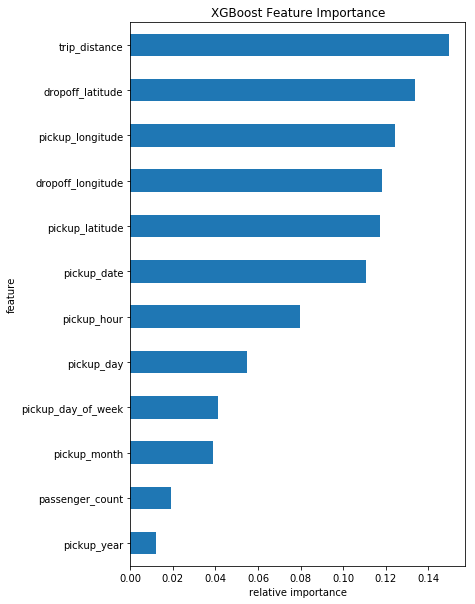

In [361]:
importance = xgb_model_tun.get_fscore()
importance = sorted(importance.items())

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
df=df.sort_values("fscore", ascending = True)
plt.figure()
# df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
# plt.gcf().savefig('feature_importance_xgb.png')

### Predicting Final Test Data 

In [403]:

col=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'pickup_date', 'pickup_day', 'pickup_hour', 'pickup_month', 'pickup_year', 'pickup_day_of_week', 'trip_distance']
final_test_data=final_test_data[col]
test_data_Wfare=final_test_data.copy()


In [402]:
dfinal_test_data=xgb.DMatrix(final_test_data)
y_pred = xgb_model_tun.predict(dfinal_test_data) # Predict using our xbg_model


In [411]:
y_pred

array([ 8.490119 ,  8.671526 ,  4.5747404, ..., 14.751655 , 15.889195 ,
        5.665361 ], dtype=float32)

In [404]:
test_data_Wfare['fare_amount']=y_pred

In [405]:
test_data_Wfare.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,pickup_hour,pickup_month,pickup_year,pickup_day_of_week,trip_distance,fare_amount
0,-73.973320,40.763805,-73.981430,40.743835,1,1133.0,27,13,1,2015,2,1.443607,8.490119
1,-73.986862,40.719383,-73.998886,40.739201,1,1133.0,27,13,1,2015,2,1.507044,8.671526
2,-73.982524,40.751260,-73.979654,40.746139,1,513.0,8,11,10,2011,6,0.384398,4.574740
3,-73.981160,40.767807,-73.990448,40.751635,1,715.0,1,21,12,2012,6,1.218529,7.862522
4,-73.966046,40.789775,-73.988565,40.744427,1,715.0,1,21,12,2012,6,3.347514,13.468697
